```{contents}
```

# Cost Function

DBSCAN does not use a **cost function** in the way algorithms like K-Means or PCA do. Instead, it is **rule-based**: clusters are defined by density conditions. Still, we can frame its logic mathematically.

---

### **1. Implicit Objective of DBSCAN**

The algorithm seeks a partition of dataset $D$ into:

* Clusters = maximal sets of density-connected points.
* Noise = points not assigned to any cluster.

No optimization of a global scalar function happens. Instead, clustering emerges from **local density checks**.

---

### **2. Local Rules (instead of cost function)**

* **Neighborhood condition**:

$$
N_\epsilon(p) = \{ q \in D \ | \ \text{dist}(p,q) \leq \epsilon \}
$$

* **Core condition**:

$$
|N_\epsilon(p)| \geq \text{minPts}
$$

* **Cluster condition**:
  Clusters are unions of points that are mutually **density-connected**.

---

### **3. Why no global cost function?**

* DBSCAN does not optimize inter-cluster variance or distances.
* It is **deterministic given $\epsilon$ and minPts**.
* Different parameter choices produce different clusterings.

---

### **4. How to evaluate DBSCAN output (proxy cost functions)**

Since there’s no internal objective, external metrics are used:

* **Silhouette coefficient**

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

where $a(i)$ = average intra-cluster distance, $b(i)$ = nearest-cluster distance.

* **Davies–Bouldin Index**: ratio of within-cluster scatter to between-cluster separation.

* **Adjusted Rand Index (ARI)** or **Mutual Information** if ground-truth labels exist.

---

**Summary**

* DBSCAN has **no explicit cost function**.
* It uses **density-based rules** instead of optimization.
* Quality of clustering is judged via **external evaluation metrics**.



Dataset: Moons (good for DBSCAN)
 eps=0.25, minPts=5
 Number of clusters (excluding noise): 2
 Number of noise points: 0
 Silhouette score: 0.3298
 Davies-Bouldin index: 1.1514
 Adjusted Rand Index (vs true labels): 1.0000
------------------------------------------------------------
Dataset: Blobs (varying density)
 eps=0.6, minPts=5
 Number of clusters (excluding noise): 3
 Number of noise points: 72
 Silhouette score: 0.3689
 Davies-Bouldin index: 1.7966
 Adjusted Rand Index (vs true labels): 0.5813
------------------------------------------------------------


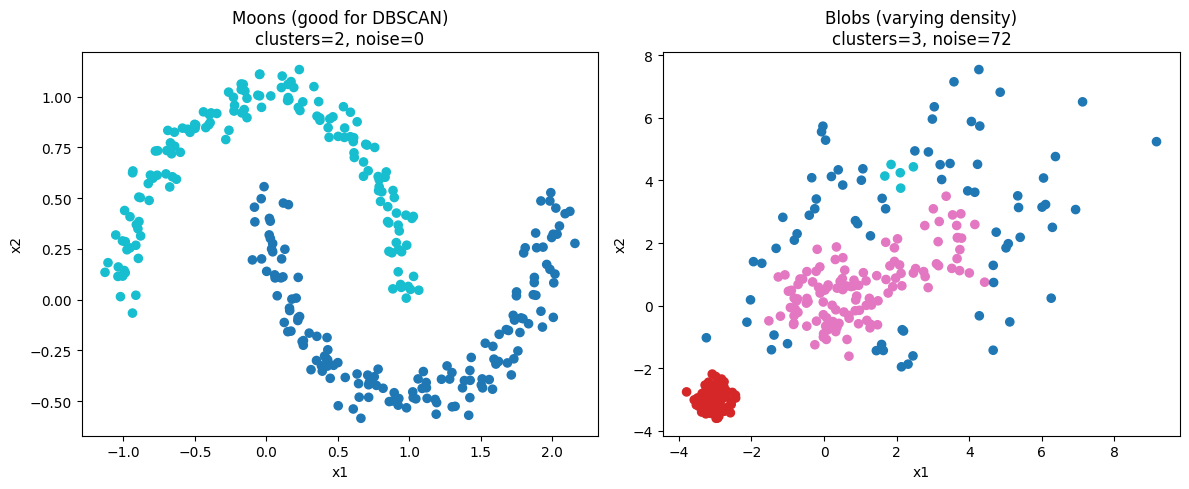

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score

# Prepare datasets
X_moons, y_moons = make_moons(n_samples=300, noise=0.06, random_state=42)
X_blobs, y_blobs = make_blobs(n_samples=300, centers=[(-3, -3), (0, 0), (3, 3)], 
                              cluster_std=[0.3, 1.0, 2.0], random_state=42)

datasets = [
    ("Moons (good for DBSCAN)", X_moons, y_moons, 0.25, 5),
    ("Blobs (varying density)", X_blobs, y_blobs, 0.6, 5),
]

results = []

for name, X, y_true, eps, minPts in datasets:
    db = DBSCAN(eps=eps, min_samples=minPts).fit(X)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise = list(labels).count(-1)
    
    # Compute evaluation metrics when applicable
    metrics = {}
    metrics['n_clusters'] = n_clusters
    metrics['n_noise'] = n_noise
    metrics['eps'] = eps
    metrics['minPts'] = minPts
    
    if n_clusters >= 2:
        metrics['silhouette'] = silhouette_score(X, labels)
        metrics['davies_bouldin'] = davies_bouldin_score(X, labels)
    else:
        metrics['silhouette'] = None
        metrics['davies_bouldin'] = None
    
    # ARI vs ground truth (tolerates noise label -1)
    metrics['ARI'] = adjusted_rand_score(y_true, labels)
    
    results.append((name, X, labels, metrics))

# Print results
for name, X, labels, metrics in results:
    print(f"Dataset: {name}")
    print(f" eps={metrics['eps']}, minPts={metrics['minPts']}")
    print(f" Number of clusters (excluding noise): {metrics['n_clusters']}")
    print(f" Number of noise points: {metrics['n_noise']}")
    if metrics['silhouette'] is not None:
        print(f" Silhouette score: {metrics['silhouette']:.4f}")
        print(f" Davies-Bouldin index: {metrics['davies_bouldin']:.4f}")
    else:
        print(" Silhouette score: Not computed (requires >= 2 clusters)")
        print(" Davies-Bouldin index: Not computed (requires >= 2 clusters)")
    print(f" Adjusted Rand Index (vs true labels): {metrics['ARI']:.4f}")
    print("-" * 60)

# Plot each dataset separately as required
# Redo visualization with subplots for clarity
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for ax, (name, X, labels, metrics) in zip(axs, results):
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=35, cmap="tab10")
    ax.set_title(f"{name}\nclusters={metrics['n_clusters']}, noise={metrics['n_noise']}")
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")

plt.tight_layout()
plt.show()



Results below.

Moons dataset: 2 clusters, 0 noise. Silhouette 0.3298. Davies–Bouldin 1.1514. ARI 1.0000.
Blobs (varying density): 3 clusters, 72 noise points. Silhouette 0.3689. Davies–Bouldin 1.7966. ARI 0.5813.

Interpretation, short:

* Silhouette near 0.3 indicates moderate cluster separation.
* Lower Davies–Bouldin is better. Moons fit DBSCAN shape assumptions so metrics are strong and ARI is 1.0.
* Blobs show many noise points and lower ARI. This reflects DBSCAN's single global density assumption failing when clusters have different densities.

Would you like the code used or a version where I sweep eps and minPts and show metric trends?
